# Homework \#4

## Problem 1 -- Least Squares in general

### The small problem

The following set of five equations in four variables does not have a unique solution. (Most problem with five equations and four variables don't.) In other words, this is an _overdetermined_ system of linear equations.


\begin{align}
&x_1 + x_2 + x_3 + x_4 = 3\\
&2x_1\phantom{+x_2+x_3}-x_4 = 1\\
&\phantom{x_1}-3x_2 + x_3 \phantom{+x_4}= 0\\
&x_1 -x_2 \phantom{+x_3}-x_4 = -1\\
&\phantom{x_1+x_2}2x_3 + 3x_4 = 6
\end{align}

(a) Write a _linear_ programming instance that will minimize the total residual: 
\begin{align}
r_1 + r_2 + r_3 + r_4 + r_5
\end{align}

where $r_i$ is defined as the absolute value of the error in the $i$th equation for a given value of $x$: $|\sum_{j=1}^{4} a_{ij}x_j - b_i|$.

Solve this problem instance in Julia.  Display both the (minimum) total residual and the values of $x$ that achieve this.

In [1]:
using JuMP, Gurobi, Cbc

A = [1  1 1  1;
     2  0 0 -1;
     0 -3 1  0;
     1 -1 0 -1;
     0  0 2  3]

b = [3, 1, 0, -1, 6]

m = Model(Gurobi.Optimizer)
set_silent(m)

@variable(m, x[1:4])
@variable(m, t[1:5] >= 0)
@constraint(m, t .>= b .- A*x)
@constraint(m, t .>= A*x .- b)
@objective(m, Min, sum(t))

optimize!(m)
xopt = value.(x)
println("\nx: ", xopt)
println("total residual: ", objective_value(m))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

x: [2.0, -0.5, -1.5, 3.0]
total residual: 0.5


(b) Write a _linear_ programming instance that will minimize the _maximum_ residual in any one equation. In other words, find values of $x$ that will $\min \max\{r_1, r_2, r_3, r_4, r_5\}.$ Solve the problem in Julia. What is the minimum max-residual that can be achieved?

In [2]:
using JuMP, Gurobi

m = Model(Gurobi.Optimizer)
set_silent(m)

@variable(m, x[1:4])
@variable(m, r)
@constraint(m, r .>= b .- A*x)
@constraint(m, r .>= A*x .- b)
@objective(m, Min, r)

optimize!(m)
xopt = value.(x)
println("\nx: ", xopt)
println("minimum max-residual: ", objective_value(m))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

x: [2.25, -0.75, -2.5, 3.75]
minimum max-residual: 0.25


### The big problem

Let $J = \{1, 2, \ldots, |J|\}$ be a set representing the indices of your decision variables for some number of variables $|J|$. You are given a set of a total of $|I| > |J|$ equations containing these decision variables in the form:
\begin{align}
\sum_{j \in J} a_{ij} x_j = b_i \qquad \forall i \in I 
\end{align}
Define the absolute residual of each equation $i \in I$ for a given choice of variable values $x^*$ as the quantity
$r_i(x^*) = | \sum_{j \in J} (a_{ij} x_j) - b_i | \qquad \forall
i \in I.$

(c) Write a _linear_ programming instance that will minimize the total residual: 
\begin{align}
\sum_{i\in I} r_i.
\end{align}
Solve this problem instance in Julia.  Display the (minimum) total residual.


(d) Write a _linear_ programming instance that will minimize the _maximum_ residual in any one equation. In other words, find values of $x$ that will $\min \max_{i\in I}\{r_i\}.$ Solve the problem in Julia. What is the minimum max-residual that can be achieved?

In [3]:
nr = 400 # number of rows of the coefficient matrix (number of equations)
nc = 200 # number of columns of the coefficient matrix (number of decision variables)

A = zeros(nr,nc) # initialize coefficient matrix
b = zeros(nr) # initialize right-hand side of equations

for i in 1:nr
    b[i] = rand(-75:75) # generate random right-hand side
    for j in 1:nc
        A[i,j] = rand(-7:7) # generate random coefficient
    end
end

using JuMP, Gurobi, Cbc

m = Model(Gurobi.Optimizer)
set_silent(m)

# (c)
@variable(m, x[1:nc])
@variable(m, t[1:nr] >= 0)
@constraint(m, t .>= b .- A*x)
@constraint(m, t .>= A*x .- b)
@objective(m, Min, sum(t))

optimize!(m)
xopt = value.(x)
topt = value.(t)
println("\nCase1: Minimizing sum of absolute values")
println("the absolute residual of each equation (t, first 10): \n", topt[1:10])
println("(c) total residual: ", objective_value(m))

# (d)
@variable(m, r)
@constraint(m, r .>= b .- A*x)
@constraint(m, r .>= A*x .- b)
@objective(m, Min, r)

optimize!(m)
xopt = value.(x)
println("\nCase2: Minimizing the largest absolute value")
println("the absolute residual of each equation (first 10): \n",  abs.(b .- A*xopt)[1:10])
println("(d) minimum max-residual: ", objective_value(m))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

Case1: Minimizing sum of absolute values
the absolute residual of each equation (t, first 10): 
[69.55232133521903, 0.0, 26.958714295626116, 0.0, 72.89023672546398, 32.5503607600863, 4.0432422012000995, 0.0, 70.25295848652206, 21.7595757498654]
(c) total residual: 8465.296594919962

Case2: Minimizing the largest absolute value
the absolute residual of each equation (first 10): 
[44.836788306426534, 13.899839752022007, 3.1535072198328926, 44.83678830642627, 5.561886196468301, 44.83678830642648, 14.4092287724589, 18.32779866505576, 44.83678830642651, 15.174208405985567]
(d) minimum max-residual: 44.8367883064265


## Problem 2 -- Curve fitting

Our favorite local microbrewery is BACK with yet another optimization dilemma. This time, they are trying to understand the relationship between using a certain type of hops to brew their beers and customer satisfaction. They surveyed a focus group by having them taste a series of beers with different concentrations of the hops and rating the flavor on a scale of 1-10. The average rating was recorded for each hop concentration. The following table summarizes the results of this survey.

|Hops (\%)|0.5|0.8|0.9|1.1|1.5|1.7|2.0|2.1|2.4|2.5|
|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|
|Satisfaction|7.8|8.1|9.0|8.9|8.5|7.1|6.8|7.7|9.3|8.5|

(a) Graph the data on a 2D plot (I recommend using the Plots package). Treat the hops concentration as the independent ($x$) variable and the satisfaction as the dependent ($y$) variable.

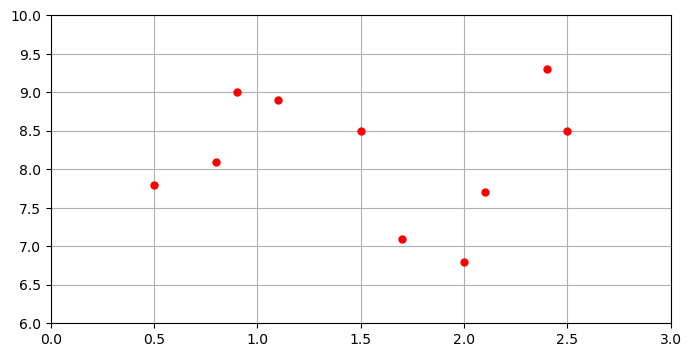

In [4]:
# define (x,y) coordinates of the points
x = [ 0.5, 0.8, 0.9, 1.1, 1.5, 1.7, 2.0, 2.1, 2.4, 2.5 ]
y = [ 7.8, 8.1, 9.0, 8.9, 8.5, 7.1, 6.8, 7.7, 9.3, 8.5 ]

# We can use the PyPlot package to graph these points
using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
axis([0, 3, 6, 10])
grid()

(b) A machine learning consultant hired by the microbrewery thinks they might be able to build a function that describes the relationship between the hop concentration and customer satisfaction so the microbrewery can select the concentration that leads to the highest overall satisfaction. To start, the consultant proposes the function:

$y = ax + be^x + c\sin(x) + d$

where $x$ is the hop concentration, $y$ is customer satisfaction, and $a, b, c, d$ are unknown constants (weights).  What values of $a, b, c, d$ give the best match between the function model and the given data? What is the resulting 2-norm error between the data and the model?

In [5]:
# order of polynomial to use
k = 3

# our matrix A will need to have m rows, where m is the number of data points
m = length(x)
# initialize A to be a matrix of zeros with m rows and k+1 columns
A1 = zeros(m, k+1)

# now loop over each row and each column
for i = 1:m
    for j = 1:k+1
        if j == 1
            A1[i,j] = x[i]
        elseif j == 2
            A1[i,j] = exp(x[i])
        elseif j == 3
            A1[i,j] = sin(x[i])
        elseif j == 4
            A1[i,j] = 1
        end
    end
end
display(A1)

using JuMP, Gurobi

m = Model(Gurobi.Optimizer)

@variable(m, u[1:k+1]) # u = [a b c d]
@objective(m, Min, sum( (y - A1*u).^2 ) )
set_silent(m)

optimize!(m)
uopt = value.(u)
println("\nvalues of abcd: ", uopt)
println("the resulting 2-norm error: ", objective_value(m))
# println("A1\\y: ", A1\y)

10×4 Matrix{Float64}:
 0.5   1.64872  0.479426  1.0
 0.8   2.22554  0.717356  1.0
 0.9   2.4596   0.783327  1.0
 1.1   3.00417  0.891207  1.0
 1.5   4.48169  0.997495  1.0
 1.7   5.47395  0.991665  1.0
 2.0   7.38906  0.909297  1.0
 2.1   8.16617  0.863209  1.0
 2.4  11.0232   0.675463  1.0
 2.5  12.1825   0.598472  1.0

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

values of abcd: [-19.924056668179997, 3.6982140271313466, 18.848801249069457, 2.6788752505236424]
the resulting 2-norm error: 2.6644489418487183


(c) Suppose another consultant argues that the better fit for this data would be a polynomial function of the form $y = a_1x^3 + a_2x^2 + a_3x + a_4$ (3rd degree poynomial).  What values of $a$ give the best match between your polynomial model and the given data? What is the resulting 2-norm error between the data and your model?

In [6]:
k = 3
m = length(x)
A2 = zeros(m,k+1)

for i = 1:m
    for j = 1:k+1
        A2[i,j] = x[i]^(k+1-j)
    end
end
display(A2)

using JuMP, Gurobi

m = Model(Gurobi.Optimizer)

@variable(m, v[1:k+1])
@objective(m, Min, sum( (y - A2*v).^2 ) )
set_silent(m)

optimize!(m)
vopt = value.(v)
println("\nvalues of a: ", vopt)
println("the resulting 2-norm error: ", objective_value(m))

10×4 Matrix{Float64}:
  0.125  0.25  0.5  1.0
  0.512  0.64  0.8  1.0
  0.729  0.81  0.9  1.0
  1.331  1.21  1.1  1.0
  3.375  2.25  1.5  1.0
  4.913  2.89  1.7  1.0
  8.0    4.0   2.0  1.0
  9.261  4.41  2.1  1.0
 13.824  5.76  2.4  1.0
 15.625  6.25  2.5  1.0

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

values of a: [2.859270229526782, -12.457502218693941, 15.932207089995357, 2.4450282378752792]
the resulting 2-norm error: 2.4000170395617033


(d) Graph the curves against your data. What value would you expect to get with an input of $x = 0.01$ in each case? Which model do you believe describes the data better, and why?

**Answer:** With an input of $x = 0.01$, I would expect to get values of 6.40 and 2.60, respectively, from the two models. The second model describes the data better because it has a lower 2-norm error (2.40) compared to the first model's 2-norm error (2.66).


case: y = ax + be^x + csin(x) + d
with an input of x = 0.01, the result is 6.403501250898399

case: y = a_1x^3 + a_2x^2 + a_3x + a_4
with an input of x = 0.01, the result is 2.603107417823593


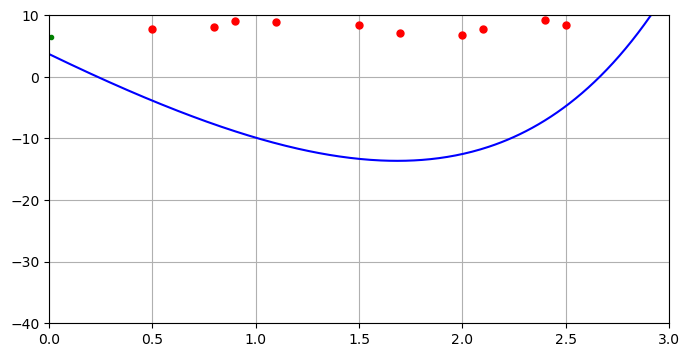

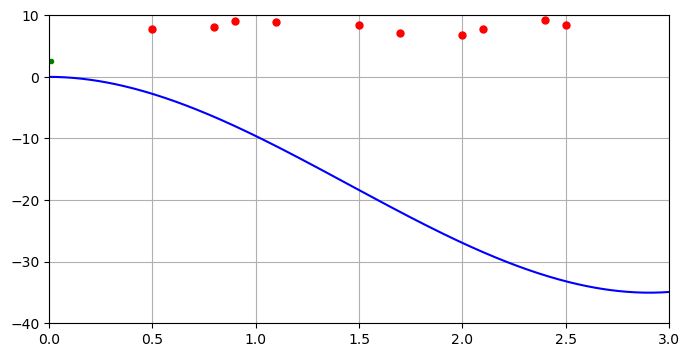

In [7]:
println("case: y = ax + be^x + csin(x) + d")
inp = 0.01
inp_ls = [inp, exp(inp), sin(inp), 1]
case1 = inp_ls'*uopt
# inp_res = uopt[1] * inp + uopt[2] * exp(inp) + uopt[3] * sin(inp) + uopt[4]
println("with an input of x = 0.01, the result is ", case1)

using PyPlot

npts = 300
x_poly = range(0,stop=3,length=npts)
# initialize the output vector with all zeros
y_poly = zeros(npts)

# calculate what each output should be using our polynomial
for j = 1:npts
    y_poly[j] = uopt[1] * x_poly[j] + uopt[2] * exp(x_poly[j]) 
                + uopt[3] * sin(x_poly[j]) + uopt[4]
end

# graph the observed data against the point
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( x_poly, y_poly, "b-")
plot( inp, case1, "g.")
axis([0, 3, -40, 10])
grid()

println("\ncase: y = a_1x^3 + a_2x^2 + a_3x + a_4")
inp_ls = [inp^3, inp^2, inp, 1]
case2 = inp_ls'*vopt
println("with an input of x = 0.01, the result is ", case2 )

y_poly = zeros(npts)

for j = 1:npts
    y_poly[j] = vopt[1] * x_poly[j]^3 + vopt[2] * x_poly[j]^2 
                + vopt[3] * x_poly[j] + vopt[4]
end

figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( x_poly, y_poly, "b-")
plot( inp, case2, "g.")
axis([0, 3, -40, 10])
grid()

## Problem 3 - Lots of Norms


A local cheese maker has a dilemma. She is checking her inventory sheets for her Gouda production and something seems wrong. Her sheets say that over the last 3 weeks, demand was met (exactly), and the demand each of those weeks was 5, 6, and 4, respectively. The problem is, things aren't adding up. She uses two variables to keep track of how much she sells: the average inventory level (I) and the average production level (P). According to her inventory sheets, 2 times the average inventory plus 2 times the average production was used to meet demand in week 1. One times the average inventory plus 3 times the average production met demand in week 2, and 3 times the average inventory minus the average production met demand in week 3.

She has used this information to write down the following equations:

\begin{eqnarray*}
 2I +2 P & = & 5\\
I + 3 P & = & 6\\
3I - P & = & 4\\
\end{eqnarray*}

The cheese maker needs to know her average inventory and production levels in the last 3 weeks, but she also knows she can't solve this problem exactly since the system is overdetermined.

(a) Formulate a _linear program_ that will find a solution $(I,P)$ that will minimize the _total_ absolute deviation (i.e., 1-norm) in the three equations. Solve the problem using any approach covered in this class and report your $(I,P)$ values and corresponding 1-norm.


In [8]:
A = [2  2;
     1  3;
     3 -1]

b = [5, 6, 4]

using JuMP, Gurobi
m = Model(Gurobi.Optimizer)
set_silent(m)

@variable(m, x[1:2]) # I, P
@variable(m, t[1:3])
@constraint(m, t .>= b .- A*x)
@constraint(m, t .>= A*x .- b)
@objective(m, Min, sum(t))

optimize!(m)
xopt = value.(x)
println("\n(I, P): ", xopt)
println("1-norm: ", objective_value(m))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

(I, P): [1.8, 1.4000000000000001]
1-norm: 1.4000000000000004


(b) The cheese maker is unhappy with the values given in part (a) and decides perhaps linear programming isn't the right approach and she should try to minimize the 2-norm of the violation of the equations instead. Modify your answer to Problem 3(a) to enforce this. Add one final constraint to your problem that _must_ be met, even if the other constraints are not met: $I + P = 3$. Write down your complete (nonlinear) optimization model. 


In [9]:
using JuMP, Gurobi

m = Model(Gurobi.Optimizer)
set_silent(m)

@variable(m, x[1:2]) # I, P
@constraint(m, x[1] + x[2] == 3)
@objective(m, Min, sum((b - A*x).^2 ))

optimize!(m)
xopt = value.(x)
println("\n(I, P): ", xopt)
println("2-norm: ", objective_value(m))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

(I, P): [1.6999999999990372, 1.30000000000093]
2-norm: 1.2000000000009123


(c) Write a set of _linear_ equalities that will give you the optimal solution to Problem 3(b). Solve this system of equations using any approach covered in this class and report the final $(I,P)$ values and corresponding 2-norm. 

\begin{eqnarray*}
 2I +2 P & = & 5\\
I + 3 P & = & 6\\
3I - P & = & 4\\
I + P & = & 3\\
\end{eqnarray*}

In [10]:
A = [2  2;
     1  3;
     3 -1;
     1  1]

b = [5, 6, 4, 3]

using JuMP, Gurobi
m = Model(Gurobi.Optimizer)
set_silent(m)

@variable(m, x[1:2]) # I, P
@objective(m, Min, sum((b - A*x).^2 ))

optimize!(m)
xopt = value.(x)
println("\n(I, P): ", xopt)
println("2-norm: ", objective_value(m))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17

(I, P): [1.649999999994271, 1.2500000000001046]
2-norm: 1.1000000000009607
